In [41]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import numpy

In [42]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [43]:
# 定义模型
def model(t_u,w,b):
    return w*t_u+b

In [44]:
# 定义损失函数
def loss_fn(t_p,t_c):
    squared_diffs=(t_p-t_c)**2
    return squared_diffs.mean()

In [45]:
# 初始化参数
params=torch.tensor([1.0,0.0],requires_grad=True)

使用pytorch中的autograd自动求梯度，你需要做的就是从将require_grad设置为True开始，然后调用模型，计算损失值，然后对损失张量loss调用backward

In [46]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()
params.grad


tensor([4517.2969,   82.6000])

本例中，params的grad属性包含损失关于params的每个元素的导数
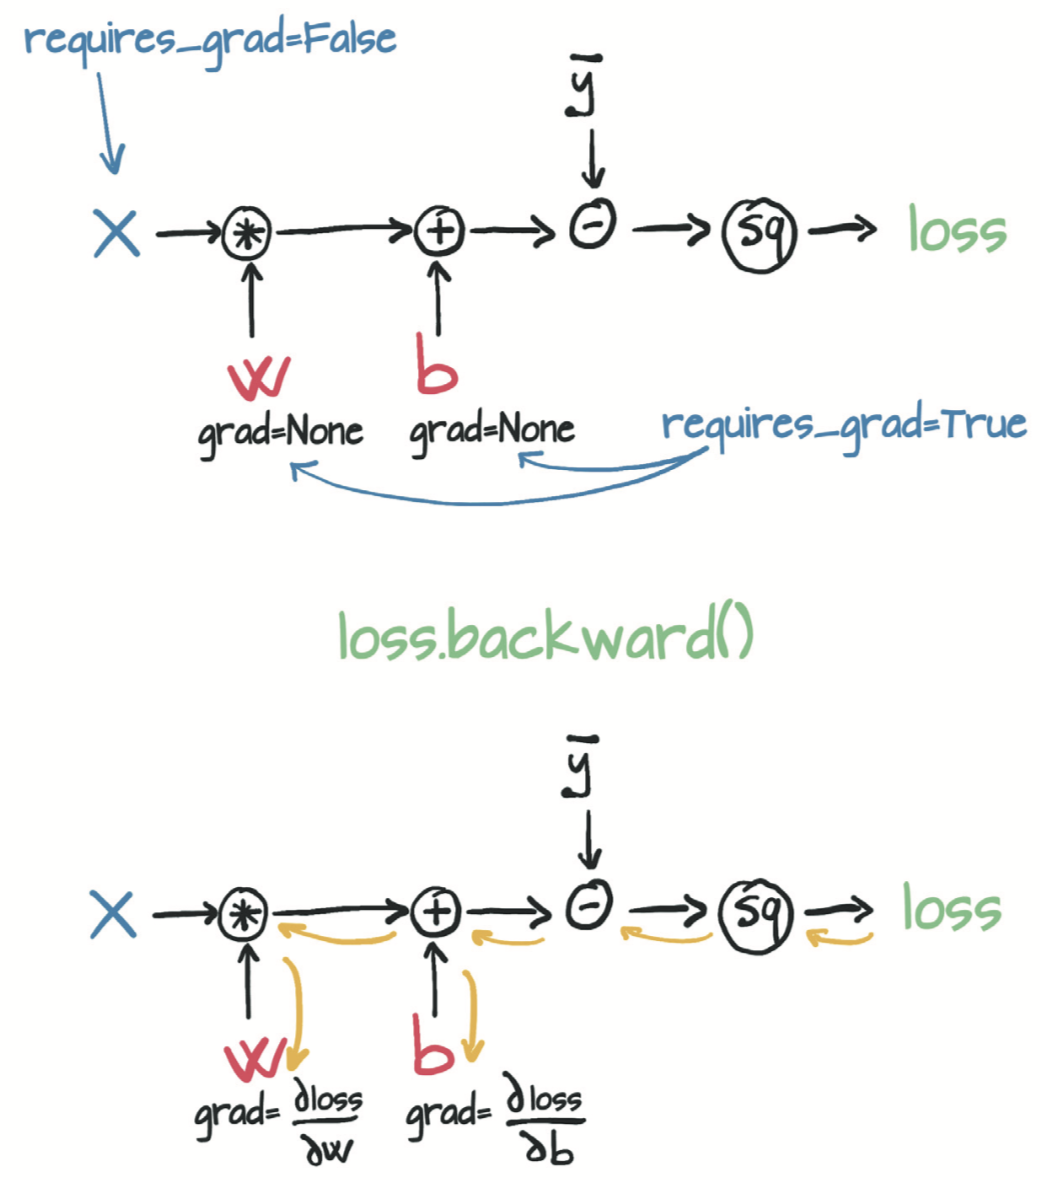
调用backward会导致导数值在叶节点处累积。所以将其用于参数更新后，需要将梯度显式清零

In [58]:
# 使用autograd自动求导来写训练循环函数
def training_loop(n_epochs,learning_rate,params,t_u,t_c,print_params=True,verbose=500):
    for epoch in range(1,n_epochs+1):
        if(params.grad is not None):
            params.grad.zero_()
        t_p=model(t_u,*params)
        loss=loss_fn(t_p,t_c)
        loss.backward()
        params=(params-learning_rate*params.grad).detach().requires_grad_()
        if(epoch%verbose==0):
            print('Epoch %d, Loss %f' %(epoch,float(loss)))
            if(print_params is True):
                print('\tParams: ',params)
                print('\tGrad: ',params.grad) # 这里就获取不到梯度信息了
    return params

In [59]:
t_un=0.1*t_u
# 调用训练循环
training_loop(n_epochs=5000,learning_rate=1e-2,params=torch.tensor([1.0,0.0],requires_grad=True),t_u=t_un,t_c=t_c)

Epoch 500, Loss 7.860115
	Params:  tensor([ 4.0443, -9.8133], requires_grad=True)
	Grad:  None
Epoch 1000, Loss 3.828538
	Params:  tensor([  4.8021, -14.1031], requires_grad=True)
	Grad:  None
Epoch 1500, Loss 3.092191
	Params:  tensor([  5.1260, -15.9365], requires_grad=True)
	Grad:  None
Epoch 2000, Loss 2.957698
	Params:  tensor([  5.2644, -16.7200], requires_grad=True)
	Grad:  None
Epoch 2500, Loss 2.933134
	Params:  tensor([  5.3236, -17.0549], requires_grad=True)
	Grad:  None
Epoch 3000, Loss 2.928648
	Params:  tensor([  5.3489, -17.1980], requires_grad=True)
	Grad:  None
Epoch 3500, Loss 2.927830
	Params:  tensor([  5.3597, -17.2591], requires_grad=True)
	Grad:  None
Epoch 4000, Loss 2.927679
	Params:  tensor([  5.3643, -17.2853], requires_grad=True)
	Grad:  None
Epoch 4500, Loss 2.927652
	Params:  tensor([  5.3662, -17.2964], requires_grad=True)
	Grad:  None
Epoch 5000, Loss 2.927647
	Params:  tensor([  5.3671, -17.3012], requires_grad=True)
	Grad:  None


tensor([  5.3671, -17.3012], requires_grad=True)

刚才是使用梯度下降的方法来让参数收敛，还有很多其他的优化算法，在torch的optim优化器模块中

In [61]:
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

优化器的工作原理
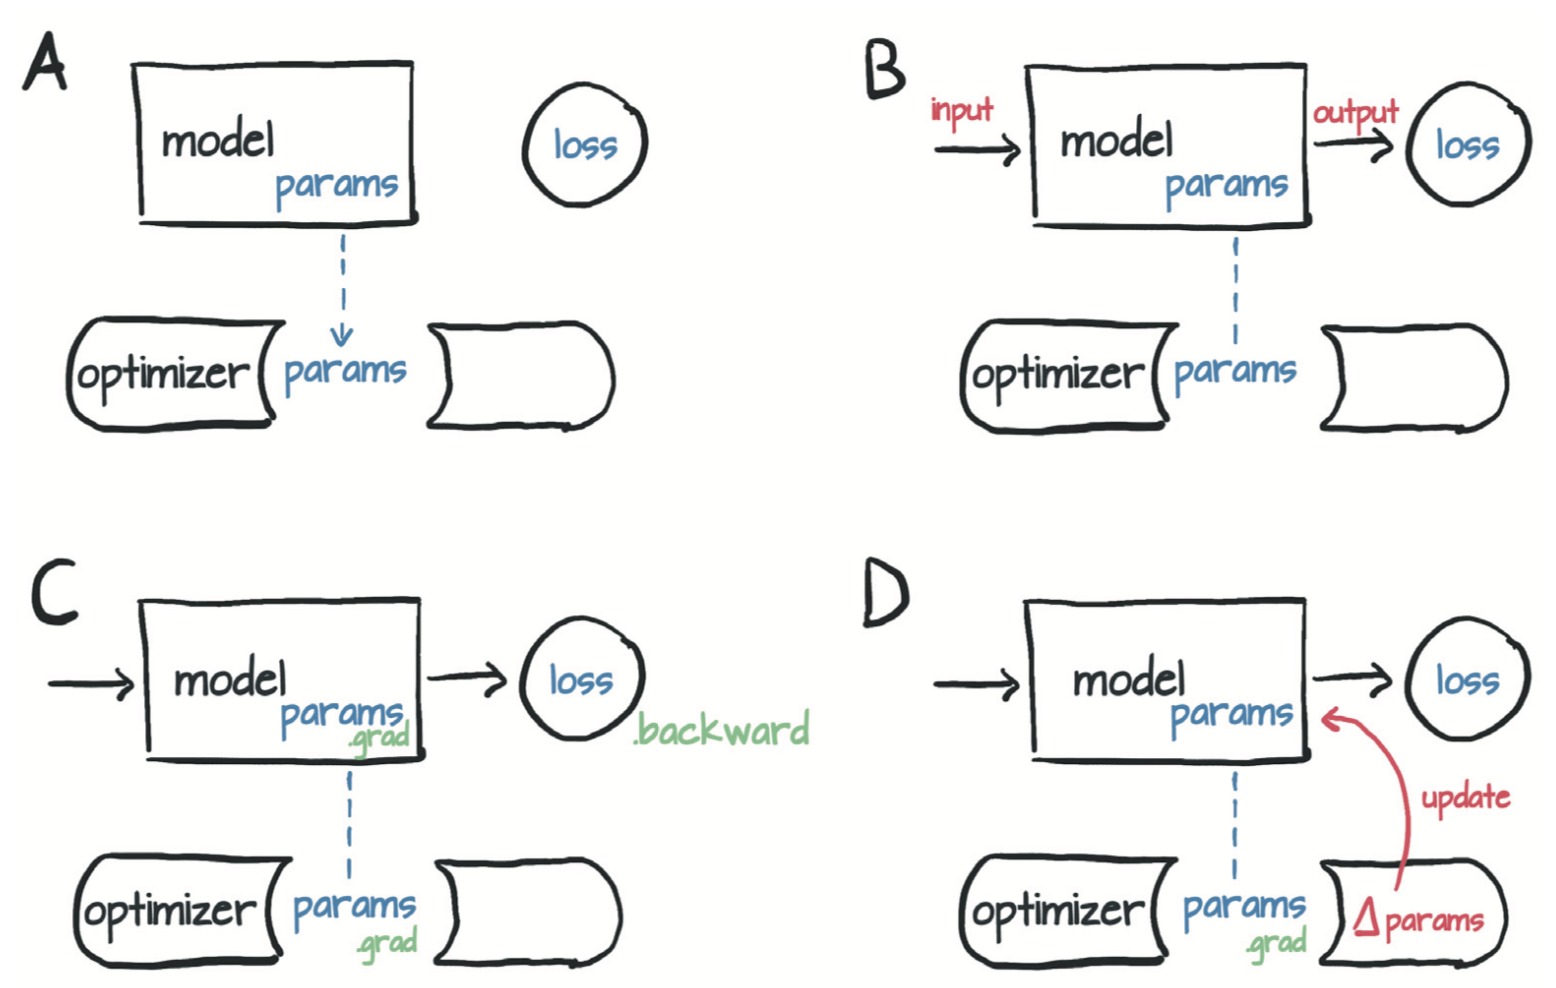
（A）优化器对参数的引用的概念表示，然后（B）根据输入计算损失，（C）对backward的调用会将grad填充到参数内。此时，（D）优化器可以访问grad并计算参数更新

In [78]:
# 使用随机梯度下降（SGD）优化器
params=torch.tensor([1.0,0.0],requires_grad=True)
learning_rate=1e-5
optimizer=optim.SGD([params],lr=learning_rate)

每个优化器都有两个方法：zero_grad和step。前者将构造时传递给优化器的所有参数的grad属性归零；后者根据特定优化器实施的优化策略更新这些参数的值。

In [79]:
t_p=model(t_u,*params)
loss=loss_fn(t_p,t_c)
loss.backward()
optimizer.step() # 这里就相当于省略了更新para的过程，即省略了params=params-learning_rate*params.grad这一步
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [85]:
# 使用优化器来进行训练循环
t_un=0.1*t_u
params=torch.tensor([1.0,0.0],requires_grad=True)
learning_rate=1e-2
optimizer=optim.SGD([params],lr=learning_rate)
t_p=model(t_un,*params)
loss=loss_fn(t_p,t_c)
optimizer.zero_grad() # 这里千万不能忘
loss.backward()
optimizer.step()
params

tensor([1.7761, 0.1064], requires_grad=True)

In [88]:
# 使用优化器中的随机梯度下降算法（SGD）来进行训练循环
def training_loop(n_epochs,optimizer,params,t_u,t_c,print_params=True,verbose=500):
    for epoch in range(1,n_epochs+1):
        t_p=model(t_u,*params)
        loss=loss_fn(t_p,t_c)
        optimizer.zero_grad() # 这里千万不能忘
        loss.backward()
        optimizer.step()
        if(epoch%verbose==0):
            print('Epoch %d, Loss %f'%(epoch,float(loss)))
            if(print_params is True):
                print('\tParams: ',params)
                print('\tGrad: ',params.grad)
    return params
t_un=0.1*t_u
params=torch.tensor([1.0,0.0],requires_grad=True)
learning_rate=1e-2
optimizer=optim.SGD([params],lr=learning_rate)
training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    params=params,
    t_u=t_un,
    t_c=t_c,
    print_params=True,
    verbose=500
)

Epoch 500, Loss 7.860115
	Params:  tensor([ 4.0443, -9.8133], requires_grad=True)
	Grad:  tensor([-0.2252,  1.2748])
Epoch 1000, Loss 3.828538
	Params:  tensor([  4.8021, -14.1031], requires_grad=True)
	Grad:  tensor([-0.0962,  0.5448])
Epoch 1500, Loss 3.092191
	Params:  tensor([  5.1260, -15.9365], requires_grad=True)
	Grad:  tensor([-0.0411,  0.2328])
Epoch 2000, Loss 2.957698
	Params:  tensor([  5.2644, -16.7200], requires_grad=True)
	Grad:  tensor([-0.0176,  0.0995])
Epoch 2500, Loss 2.933134
	Params:  tensor([  5.3236, -17.0549], requires_grad=True)
	Grad:  tensor([-0.0075,  0.0425])
Epoch 3000, Loss 2.928648
	Params:  tensor([  5.3489, -17.1980], requires_grad=True)
	Grad:  tensor([-0.0032,  0.0182])
Epoch 3500, Loss 2.927830
	Params:  tensor([  5.3597, -17.2591], requires_grad=True)
	Grad:  tensor([-0.0014,  0.0078])
Epoch 4000, Loss 2.927679
	Params:  tensor([  5.3643, -17.2853], requires_grad=True)
	Grad:  tensor([-0.0006,  0.0033])
Epoch 4500, Loss 2.927652
	Params:  tensor(

tensor([  5.3671, -17.3012], requires_grad=True)

In [91]:
# 使用优化器中的Adam算法
params=torch.tensor([1.0,0.0],requires_grad=True)
learning_rate=1e-1
optimizer=optim.Adam([params],lr=learning_rate)
training_loop(
    n_epochs=2000,
    optimizer=optimizer,
    params=params,
    t_u=t_u,
    t_c=t_c
)

Epoch 500, Loss 7.612898
	Params:  tensor([  0.4081, -10.0095], requires_grad=True)
	Grad:  tensor([-1.1790,  1.2604])
Epoch 1000, Loss 3.086700
	Params:  tensor([  0.5131, -15.9629], requires_grad=True)
	Grad:  tensor([-0.2160,  0.2322])
Epoch 1500, Loss 2.928579
	Params:  tensor([  0.5350, -17.2021], requires_grad=True)
	Grad:  tensor([-0.0169,  0.0178])
Epoch 2000, Loss 2.927644
	Params:  tensor([  0.5367, -17.3021], requires_grad=True)
	Grad:  tensor([-0.0007,  0.0005])


tensor([  0.5367, -17.3021], requires_grad=True)

为了避免过拟合，需要把数据集划分为训练集和验证集两部分

In [100]:
n_samples=t_u.shape[0]
# n_samples: 11
n_val=int(0.2*n_samples)
# n_val: 2
shuffled_indices=torch.randperm(n_samples) # randperm函数：打乱张量中的元素
train_indices=shuffled_indices[:-n_val]
val_indices=shuffled_indices[-n_val:]
train_indices,val_indices

(tensor([ 7,  3,  2,  9,  4,  1,  0,  8, 10]), tensor([5, 6]))

In [101]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u


In [102]:
# 带有训练集和验证集的训练循环
def training_loop(n_epochs, optimizer, params, 
                  train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward() # 注意没有val_loss.backward因为不能在验证集上训练模型
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print('Epoch %d, Training loss %.2f, Validation loss %.2f' % (
                    epoch, float(train_loss), float(val_loss)))
    return params

params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c)


Epoch 1, Training loss 97.13, Validation loss 4.91
Epoch 2, Training loss 39.57, Validation loss 7.70
Epoch 3, Training loss 32.78, Validation loss 15.87
Epoch 500, Training loss 8.48, Validation loss 2.64
Epoch 1000, Training loss 3.96, Validation loss 1.44
Epoch 1500, Training loss 3.11, Validation loss 2.29
Epoch 2000, Training loss 2.94, Validation loss 2.92
Epoch 2500, Training loss 2.91, Validation loss 3.24
Epoch 3000, Training loss 2.91, Validation loss 3.39


tensor([  5.4996, -18.1371], requires_grad=True)

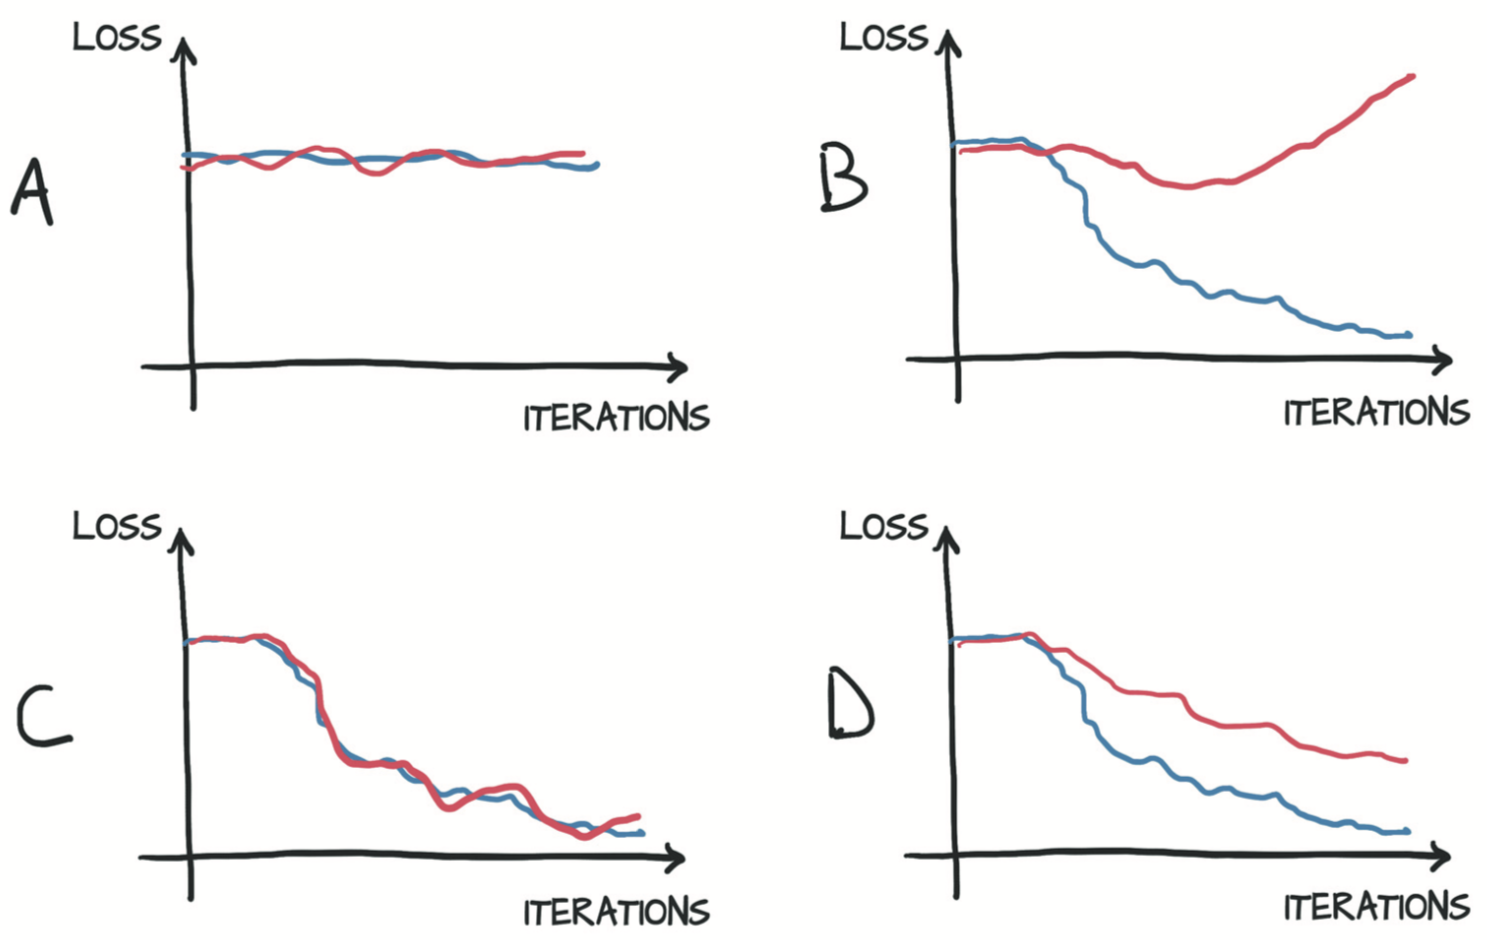
训练（蓝色）和验证（红色）损失曲线图。（A）训练和验证损失没有下降；由于数据中没有信息或模型拟合能力不足，该模型无法学习。（B）训练损失下降而验证损失增加（过拟合）。（C）训练和验证损失同步减少；由于模型并非处于过拟合的极限，因此性能可能会进一步提高。（D）训练和验证损失具有不同的绝对值但趋势相似；过拟合在可控之内。

In [103]:
# 使用torch.no_grad上下文管理器在不需要时关闭autograd
def training_loop(n_epochs, optimizer, params, 
                  train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()


In [104]:
# 使用相关的set_grad_enabled上下文管理器来选择性的运行带或不带autograd的model和loss_fn
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss
